# **Body Score Pediction**

This notebook contains step by step process for body score prediction. The steps taken are as follows ;

1. Making necessary imports
2. Data loading and preprocessing
3. Model development
4. Predictions and submission

NB: This notebook was run on a **FreeTier colab T4 gpu**. However , it is preferable to run this notebook in a **colab pro or pro+** account that has **higher Ram** to prevent unexpected crashing

## **Necessary Imports**

In [ ]:
import os
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras import losses, optimizers, layers, Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

## **Data Loading and preprocessing**

In [ ]:
#get image data
os.makedirs('body_score_dataset', exist_ok=True)
!git clone -b body_scores_prediction_dataset https://github.com/MVet-Platform/M-Vet_Hackathon24.git ./body_score_dataset

Cloning into './body_score_dataset'...
remote: Enumerating objects: 15246, done.
remote: Counting objects: 100% (3683/3683), done.
remote: Compressing objects: 100% (3664/3664), done.
remote: Total 15246 (delta 20), reused 3677 (delta 17), pack-reused 11563 (from 1)
Receiving objects: 100% (15246/15246), 1.30 GiB | 22.82 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Updating files: 100% (10878/10878), done.


In [ ]:
# Load label data
df_train_data = pd.read_csv('./body_score_dataset/train_data.csv')
df_train_data.head()

,filename,bodyScore
0,6c11338b-ce1a-4e23-b505-8d6afaf110f33796968321...,4.0
1,53c3ffb8-ccef-41bf-ae83-bc1954c436417186970590...,3.0
2,c13a8227-7747-4eac-9906-b9dee9b6e14e1858597213...,4.0
3,90bb5ad3-c9bd-4cb7-a950-62f6effad3528612499606...,4.0
4,224ef780-210b-4b9e-a4d9-1ecbff118a246705373022...,3.0


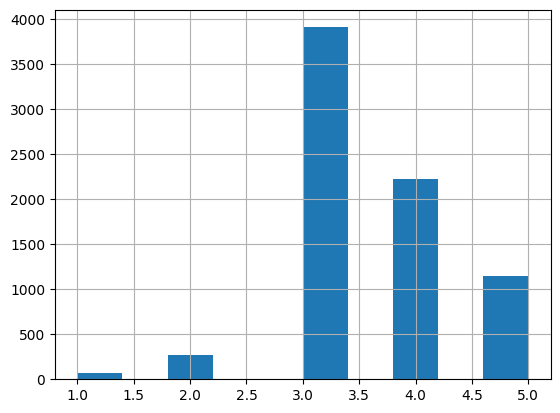

In [ ]:
df_train_data['bodyScore'].hist()
plt.show()

The visualisation above shows class imbalance.

In [ ]:
#get file path for image files
df_train_data['filepath'] = df_train_data.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)

In [ ]:
df_train_data.head()

,filename,bodyScore,filepath
0,6c11338b-ce1a-4e23-b505-8d6afaf110f33796968321...,4.0,body_score_dataset/0003/6c11338b-ce1a-4e23-b50...
1,53c3ffb8-ccef-41bf-ae83-bc1954c436417186970590...,3.0,body_score_dataset/0002/53c3ffb8-ccef-41bf-ae8...
2,c13a8227-7747-4eac-9906-b9dee9b6e14e1858597213...,4.0,body_score_dataset/0005/c13a8227-7747-4eac-990...
3,90bb5ad3-c9bd-4cb7-a950-62f6effad3528612499606...,4.0,body_score_dataset/0004/90bb5ad3-c9bd-4cb7-a95...
4,224ef780-210b-4b9e-a4d9-1ecbff118a246705373022...,3.0,body_score_dataset/0001/224ef780-210b-4b9e-a4d...


In [ ]:
#create array of body scores and file paths
body_scores = df_train_data.bodyScore.values
file_paths = df_train_data.filepath.values

In [ ]:
# Train-test split
train_paths, val_paths, train_scores, val_scores = train_test_split(
    file_paths, body_scores, test_size=0.3, random_state=42
)

In [ ]:
#  Define Image Preprocessing and Augmentation
def load_and_preprocess_image(file_path, body_score=None):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    # image = preprocess_input(image)  # EfficientNet's preprocessing
    if body_score is not None:
        return image, body_score
    else:
        return image




In [ ]:
# Prepare TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_scores))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=2000).batch(batch_size=16)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_scores))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size=16)

## **Model Development**

A brief research was carried out and EfficientNet BO was chosen to be our base model for feature extraction. Idea was motivated from https://francis-press.com/papers/10839 (Though they particularly considered the problem as a classification problem)

In [ ]:
# Model Architecture
base_model = EfficientNetB0(include_top=False, weights='imagenet', pooling='avg')

# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-119]:  # Fine-tune only the last 119 layers
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='relu')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# view trainable params

# View trainable parameters
for layer in model.layers:
    print(layer.name, layer.trainable)


efficientnetb0 True
flatten True
dense True
dropout True
dense_1 True
dense_2 True
dense_3 True


In [ ]:
# Check which layers are frozen and which are trainable
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)


0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

Efficientnet has a **block architecture** . It is more beneficial to experiment unfreezing in blocks as compared to a defined number of layers . Blocks 7, 6, 5 were unfrozen

In [ ]:
# Compile the model
model.compile(
    loss=losses.MSE,  # Mean Squared Error loss
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=['mae']  # Mean Absolute Error
)



In [ ]:
#  Callbacks for Training
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.05, patience=3, verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, restore_best_weights=True
)

In [ ]:
# Train the Model

tf.random.set_seed(42)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    batch_size=16,
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 100s 126ms/step - loss: 1.5217 - mae: 0.9425 - val_loss: 0.6007 - val_mae: 0.6144 - learning_rate: 0.0010
Epoch 2/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - loss: 0.6089 - mae: 0.6136 - val_loss: 0.6921 - val_mae: 0.6630 - learning_rate: 0.0010
Epoch 3/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - loss: 0.4677 - mae: 0.5389 - val_loss: 0.5186 - val_mae: 0.5601 - learning_rate: 0.0010
Epoch 4/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 0.3758 - mae: 0.4812 - val_loss: 0.4925 - val_mae: 0.5484 - learning_rate: 0.0010
Epoch 5/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 32s 85ms/step - loss: 0.3216 - mae: 0.4461 - val_loss: 0.8912 - val_mae: 0.7594 - learning_rate: 0.0010
Epoch 6/40
333/333 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - loss: 0.2678 - mae: 0.4013 - val_loss: 0.7363 - val_mae: 0.6612 - learning_rate: 0.0010
Epoch 7/40
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2442 - mae: 0.3849
Epoch 7: ReduceLROnPlateau reducing learning rate to

## **Making Predections and Submission**

In [ ]:

import numpy as np

# Load Test Data and Make Predictions
df_submit = pd.read_csv('./body_score_dataset/sample_submission.csv')
df_submit['filepath'] = df_submit.apply(lambda row: glob(f'body_score_dataset/**/{row.filename}')[0], axis=1)

df_submit_file_paths = df_submit.filepath.values
test_dataset = tf.data.Dataset.from_tensor_slices(df_submit_file_paths)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

# Make predictions
predictions = model.predict(test_dataset)
predictions_flattened = predictions.flatten()

# Round predictions to the nearest whole number
predictions_rounded = np.round(predictions_flattened)

# Ensure that the predictions are capped at a maximum of 5
df_submit['bodyScore'] = [5.0 if i > 5 else i for i in predictions_rounded]

# Save the results to the CSV file
df_submit[['filename', 'bodyScore']].to_csv('submission.csv', index=False)



102/102 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step
